In [72]:
import gensim
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import scipy

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True) 
len_embedding = 300

In [64]:
#Get dictionary data
path_kernel = './data/cide/cide-kernel.dig'
path_full = './data/cide/cide.dig'
kernel_tokens = {}
kernel_vectors = {}
list_kernel = []
out_of_vocab_kernel = {}
out_of_vocab_full = {}
rest_tokens = {}
rest_vectors = {}
with open(path_kernel,'r') as f:
    nb_tokens = int(f.readline())
    for i in range(nb_tokens):
        tokens = f.readline().split('|')
        number = int(tokens[0].split(':')[0])
        token = tokens[0].split(':')[1]
        try:
            kernel_vectors[number] = model[token]
            kernel_tokens[number] = [token]
        except KeyError:
            out_of_vocab_kernel[number] = token
        list_kernel.append(token)
edge_list = []
with open(path_full,'r') as f:
    lines = f.readlines()
    nb_tokens = int(lines[0])
    for i in range(1,nb_tokens+1):
        tokens = lines[i].split('|')
        number = int(tokens[0].split(':')[0])
        token = tokens[0].split(':')[1]
        if token not in list_kernel:
            try:
                rest_vectors[number] = model[token]
                rest_tokens[number] = token
            except KeyError:
                out_of_vocab_full[number] = token
    for i in range(nb_tokens+1,len(lines)):
        edge_list.append([int(x) for x in lines[i].split('->')])
        

In [40]:
len(out_of_vocab_full.values())

1142

In [80]:
#Reconstruct dictionary
dictionary = {}
for edge in edge_list:
    if not edge[1] in dictionary:
        dictionary[edge[1]] = [edge[0]]
    else:
        dictionary[edge[1]].append(edge[0])

In [81]:
known_tokens = list(kernel_tokens.keys())
out_of_vocab_tokens = list(out_of_vocab_kernel.keys()) + list(out_of_vocab_full.keys())
order_tokens = {}
order_tokens[0] = known_tokens
learned_vectors = kernel_vectors.copy()

to_define = dictionary.copy()
layer = 1
while len(to_define)>0:
    print('Layer #{}, {} left to define'.format(layer,len(to_define)))
    order_tokens[layer] = []
    new_tokens = []
    list_to_define = list(to_define.keys())
    for token in list_to_define:
        def_status = []
        definition = dictionary[token]
        for definer in definition:
            if definer in known_tokens:
                def_status.append(0)
            elif definer in out_of_vocab_tokens:
                def_status.append(1)
            else:
                def_status.append(2)
        if 0 and 2 not in def_status:
            out_of_vocab_tokens.append(token)
            del to_define[token]
        elif 2 not in def_status:
            order_tokens[layer].append(token)
            new_vector = np.zeros(len_embedding)
            for definer_i in range(len(definition)):
                if def_status[definer_i] == 0:
                    new_vector+=learned_vectors[definition[definer_i]]
            learned_vectors[token] = new_vector
            new_tokens.append(token)
            del to_define[token]
    known_tokens += new_tokens
    layer+=1
            

Layer #1, 47145 left to define
Layer #2, 21450 left to define
Layer #3, 8325 left to define
Layer #4, 3185 left to define
Layer #5, 1261 left to define
Layer #6, 404 left to define
Layer #7, 113 left to define
Layer #8, 20 left to define
Layer #9, 2 left to define


C:\Users\User1\Anaconda3\lib\site-packages\scipy\spatial\distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
C:\Users\User1\Anaconda3\lib\site-packages\scipy\spatial\distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


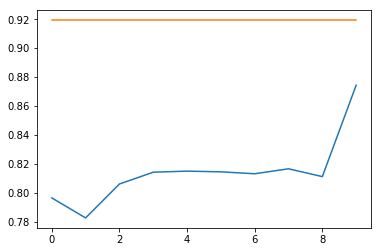

In [88]:
average_sim = []

for i in range(len(order_tokens.keys())):
    learned_tokens = order_tokens[i]
    similarities = []
    for token in learned_tokens:
        if token in rest_vectors:
            similarities.append(scipy.spatial.distance.cosine(learned_vectors[token],rest_vectors[token]))
    average_sim.append(np.nanmean(similarities))
    
random_pairs = 100000
rest_keys = list(rest_vectors.keys())
pairs = []
for i in range(random_pairs):
    numbers = np.random.randint(0,len(rest_keys),2)
    token1 = rest_keys[numbers[0]]
    token2 = rest_keys[numbers[1]]
    pairs.append(scipy.spatial.distance.cosine(rest_vectors[token1],rest_vectors[token2]))
avg_pairs = np.mean(pairs)
random_sim = np.repeat(avg_pairs,len(average_sim))
plt.plot(average_sim)
plt.plot(random_sim)
plt.show()
        


In [86]:
average_sim

[nan,
 nan,
 0.80604028762356461,
 0.81419250287063061,
 0.81493701858642864,
 0.81445402151628243,
 0.81311128029200797,
 0.81654769861552501,
 0.8111433976838498,
 0.87435673535588887]